<h1> Appliances energy prediction</h1>

### Goal

-  Forecast for Appliances

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re 
import os

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR


import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['axes.grid'] = False

### Load data

In [3]:
filepath = 'https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/appliance_energy_usage.csv'

In [6]:
df = pd.read_csv(filepath, index_col='date', parse_dates=True)

In [7]:
df

,Appliances,lights,T_out,Press_mm_hg,RH_out,Windspeed,Tdewpoint,Visibility
date,,,,,,,,
2016-01-11 17:00:00,60,30,6.600000,733.5,92.000000,7.000000,5.300000,63.000000
2016-01-11 17:10:00,60,30,6.483333,733.6,92.000000,6.666667,5.200000,59.166667
2016-01-11 17:20:00,50,30,6.366667,733.7,92.000000,6.333333,5.100000,55.333333
2016-01-11 17:30:00,50,40,6.250000,733.8,92.000000,6.000000,5.000000,51.500000
2016-01-11 17:40:00,60,40,6.133333,733.9,92.000000,5.666667,4.900000,47.666667
...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,22.733333,755.2,55.666667,3.333333,13.333333,23.666667
2016-05-27 17:30:00,90,0,22.600000,755.2,56.000000,3.500000,13.300000,24.500000
2016-05-27 17:40:00,270,10,22.466667,755.2,56.333333,3.666667,13.266667,25.333333


-  Data Is recorded every 10 minutes
-  We going to use it in aggregated Hourly data

### Convert to Hours

In [9]:
# resample to every hour
# take the mean of every hour
df = df.resample('1H').mean()

In [10]:
df.head()

,Appliances,lights,T_out,Press_mm_hg,RH_out,Windspeed,Tdewpoint,Visibility
date,,,,,,,,
2016-01-11 17:00:00,55.000000,35.000000,6.308333,733.750000,92.000000,6.166667,5.050000,53.416667
2016-01-11 18:00:00,176.666667,51.666667,5.941667,734.266667,91.583333,5.416667,4.658333,40.000000
2016-01-11 19:00:00,173.333333,25.000000,6.000000,734.791667,89.750000,6.000000,4.391667,40.000000
2016-01-11 20:00:00,125.000000,35.000000,6.000000,735.283333,87.583333,6.000000,4.016667,40.000000
2016-01-11 21:00:00,103.333333,23.333333,5.833333,735.566667,87.416667,6.000000,3.816667,40.000000


In [ ]:
color

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

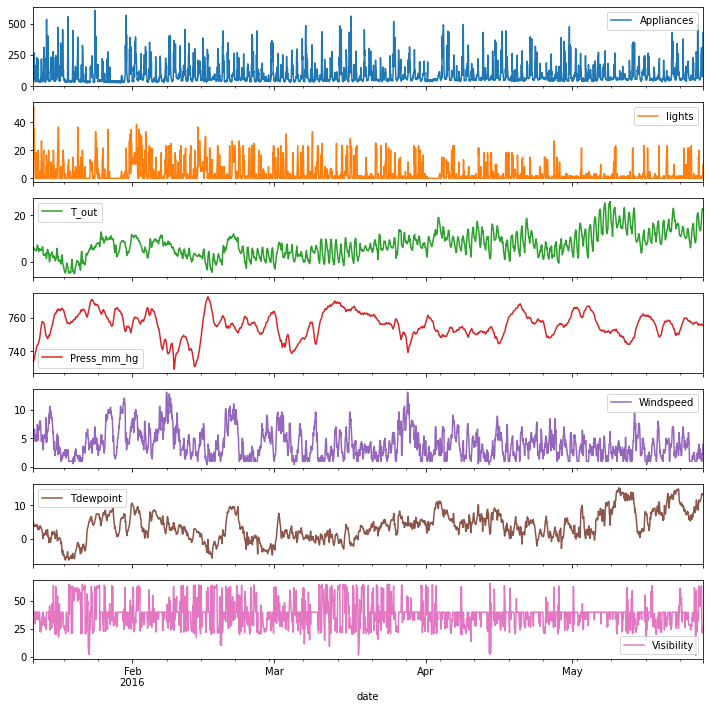

In [14]:

df[['Appliances', 'lights', 'T_out', 'Press_mm_hg', 'Windspeed', 'Tdewpoint', 'Visibility']].plot(subplots=True, figsize=(12,12))

-  Null Hypothesis - Series possesses a unit root and hence is not stationary
-  Alternate Hypothesis - Series is stationary

### Which Variables to use for our Model?

-  Run adfuller test to check for stationarity

-  H0: Xt does not granger causes Yt
-  H1: Xt granger causes Yt

In [19]:
for i in range(len(df.columns)):
    result = adfuller(df[df.columns[i]])
    
    if result[1] > 0.05:
        print('{} : series is NOT stationary'.format(df.columns[i]))
    else:
        print('{} : series IS stationary'.format(df.columns[i]))

Appliances : series IS stationary
lights : series IS stationary
T_out : series IS stationary
Press_mm_hg : series IS stationary
RH_out : series IS stationary
Windspeed : series IS stationary
Tdewpoint : series IS stationary
Visibility : series IS stationary


### Which of the variables causes appliance?
-  Use grangercausalitytests to identify which variables causes appliances
-  The Granger causality test is a statistical hypothesis test for determining whether one time series is useful for forecasting another. If probability value is less than any level, then the hypothesis would be rejected at that level.

In [22]:
max_lags = 8
y = 'Appliances'

In [23]:
for i in range(len(df.columns)-1):
    result = grangercausalitytests(df[[y, df.columns[i+1]]], maxlag = max_lags, verbose=False)
    p_values = [round(result[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
    print('Column - {} : P_Values - {}'.format(df.columns[i+1], p_values))

Column - lights : P_Values - [0.1451, 0.0005, 0.0001, 0.0002, 0.0001, 0.0001, 0.0006, 0.0012]
Column - T_out : P_Values - [0.002, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - Press_mm_hg : P_Values - [0.0985, 0.1956, 0.0351, 0.0016, 0.0, 0.0001, 0.0, 0.0]
Column - RH_out : P_Values - [0.0, 0.0004, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - Windspeed : P_Values - [0.0004, 0.0041, 0.0094, 0.0082, 0.0163, 0.0119, 0.0009, 0.0002]
Column - Tdewpoint : P_Values - [0.4348, 0.4494, 0.5005, 0.3887, 0.05, 0.0694, 0.0992, 0.1152]
Column - Visibility : P_Values - [0.7071, 0.5372, 0.7338, 0.8265, 0.544, 0.3324, 0.2521, 0.3465]


-  T_Out granger causes the Appliance, p_value is less than 0.05 (see all lags)
-  Windspeed granger causes Appliance, p_value is less than 0.05 (see all lags)

-  Press_mm_hg also granger causes appliance fro lag3, we can still use it but in this case we will exclude it.

In [24]:
df_input = df[['Appliances', 'T_out', 'Windspeed']]

In [26]:
df_input.head()

,Appliances,T_out,Windspeed
date,,,
2016-01-11 17:00:00,55.000000,6.308333,6.166667
2016-01-11 18:00:00,176.666667,5.941667,5.416667
2016-01-11 19:00:00,173.333333,6.000000,6.000000
2016-01-11 20:00:00,125.000000,6.000000,6.000000
2016-01-11 21:00:00,103.333333,5.833333,6.000000


### Train Test Split

-  Since its a timeseries data, we will not  use random split to ensure that we retain the sequence

In [27]:
# 90% as training
df_train = df_input[:int(0.9*(len(df_input)))] 

# 10% as test set
df_test = df_input[int(0.9*(len(df_input))):]

In [29]:
 df_train.shape, df_test.shape,

((2961, 3), (329, 3))

### Build a VAR

-  What is a number of lags that are appliacble to our data?
-  The crude way is to run all the lags and find out out where we get the lowest metric.
-  The more the lags the more challenges we will face

##### Crude way Approach (using 48 lags)

In [34]:
model = VAR(df_train, freq='1H')
Order = []
AIC = []
BIC = []
for i in range(48):
    results = model.fit(i+1) # fitting and training on each lag
#     print('Order = ', i+1)
#     print('AIC: ', results.aic)
#     print('BIC: ', results.bic)
    
    Order.append(i+1)
    AIC.append(results.aic)
    BIC.append(results.bic)
    
var_results = pd.DataFrame({'Order': Order,
             'AIC': AIC,
             'BIC': BIC})

var_results

,Order,AIC,BIC
0,1,7.126785,7.151081
1,2,6.138769,6.181299
2,3,6.019982,6.080756
3,4,5.960527,6.039555
4,5,5.908070,6.005362
5,6,5.891197,6.006765
6,7,5.852250,5.986103
7,8,5.841916,5.994064
8,9,5.827889,5.998343
9,10,5.825121,6.013891


##### Better way to view the summary (* highlights the minimum)

In [36]:
model.select_order(48).summary()

,AIC,BIC,FPE,HQIC
0,13.82,13.83,1.005e+06,13.82
1,7.139,7.163,1260.,7.148
2,6.149,6.192,468.3,6.165
3,6.031,6.093,416.2,6.053
4,5.970,6.050,391.7,5.999
5,5.917,6.015,371.3,5.952
6,5.902,6.019,365.7,5.944
7,5.863,5.999*,351.9,5.912
8,5.852,6.006,348.1,5.908
9,5.837,6.010,342.9,5.900


-  BIC is lowest at lags 7.

##### Recreate the VAR model with the new lags

In [37]:
model  = VAR(df_train, freq='1H')
results = model.fit(7)

In [38]:
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Oct, 2022
Time:                     04:34:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    5.98610
Nobs:                     2954.00    HQIC:                   5.90043
Log likelihood:          -21152.4    FPE:                    348.017
AIC:                      5.85225    Det(Omega_mle):         340.356
--------------------------------------------------------------------
Results for equation Appliances
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                37.865935         3.448219           10.981           0.000
L1.Appliances         0.451436         0.018470           24.442           0.000
L1.T_out              2.328238         2.534185        

##### Forecasting

In [39]:
# from the training dataset, we need to get the past lag value that we can use to get the first value of my test dataset
lag = results.k_ar

In [40]:
# forecasting for the first 5 values of the test dataset
results.forecast(df_train.values[-lag:], steps=5)

array([[44.34598018,  8.92651619,  3.99333186],
       [33.70923187,  8.81719814,  4.13871016],
       [38.32344216,  9.01953267,  4.188856  ],
       [53.39756915,  9.3356185 ,  4.31429082],
       [60.93798924,  9.56974211,  4.40093836]])

In [42]:
df_test[0:5]

,Appliances,T_out,Windspeed
date,,,
2016-05-14 02:00:00,60.000000,8.891667,3.166667
2016-05-14 03:00:00,60.000000,8.725000,2.833333
2016-05-14 04:00:00,60.000000,8.775000,4.416667
2016-05-14 05:00:00,56.666667,8.683333,5.000000
2016-05-14 06:00:00,63.333333,8.716667,5.000000


##### Creating a model that will only forecast for Appliances

In [41]:
df_coeff = pd.DataFrame([results.params['Appliances'], results.pvalues['Appliances']]).T

In [43]:
df_coeff

,Appliances,Appliances
const,37.865935,4.701032e-28
L1.Appliances,0.451436,6.138160e-132
L1.T_out,2.328238,3.582355e-01
L1.Windspeed,2.268735,2.564126e-01
L2.Appliances,0.222279,4.255512e-28
L2.T_out,-4.372626,4.302427e-01
L2.Windspeed,-1.481847,6.603327e-01
L3.Appliances,-0.019489,3.454670e-01
L3.T_out,5.606923,3.952787e-01
L3.Windspeed,0.184615,9.598961e-01


In [44]:
df_coeff.columns = ['coeff', 'pval']

-  Not all lags contribute the model
-  Pick those lags whose pvalue < 0.05

In [45]:
df_coeff.query('pval < 0.05')

,coeff,pval
const,37.865935,4.701032e-28
L1.Appliances,0.451436,6.138160e-132
L2.Appliances,0.222279,4.255512e-28
L4.Appliances,-0.043691,3.442733e-02
L7.T_out,-6.777338,8.064473e-03


In [46]:
np.where(df_coeff['pval'] < 0.05,1, 0)

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [47]:
df_coeff['valid'] = np.where(df_coeff['pval'] <0.05, 1,0)

In [48]:
df_coeff

,coeff,pval,valid
const,37.865935,4.701032e-28,1
L1.Appliances,0.451436,6.138160e-132,1
L1.T_out,2.328238,3.582355e-01,0
L1.Windspeed,2.268735,2.564126e-01,0
L2.Appliances,0.222279,4.255512e-28,1
L2.T_out,-4.372626,4.302427e-01,0
L2.Windspeed,-1.481847,6.603327e-01,0
L3.Appliances,-0.019489,3.454670e-01,0
L3.T_out,5.606923,3.952787e-01,0
L3.Windspeed,0.184615,9.598961e-01,0


##### Deploy the model using the selected params (lags)

In [49]:
# taking all the coefficients
# exclude th first value because its a constant
coeff_arr = df_coeff['coeff'][1:].values

In [50]:
# 7 legs
# 3 features
#21 coefficients
coeff_arr.shape

(21,)

In [51]:
coeff_arr

array([ 0.45143647,  2.32823846,  2.26873466,  0.2222793 , -4.37262576,
       -1.48184722, -0.01948858,  5.60692324,  0.18461514, -0.04369054,
       -5.43530357, -0.08685622,  0.00738616,  5.17191268, -1.99030973,
       -0.01683822,  3.22703425,  4.97164661, -0.01091878, -6.77733848,
       -2.97259279])

-  we will take these coefficients and mulitply them with the input value to transform into a linear equation

In [52]:
df_train[-lag:]

,Appliances,T_out,Windspeed
date,,,
2016-05-13 19:00:00,208.333333,19.333333,9.000000
2016-05-13 20:00:00,120.000000,17.066667,8.166667
2016-05-13 21:00:00,63.333333,14.116667,6.583333
2016-05-13 22:00:00,55.000000,11.850000,6.833333
2016-05-13 23:00:00,61.666667,10.466667,7.583333
2016-05-14 00:00:00,58.333333,9.791667,5.750000
2016-05-14 01:00:00,63.333333,9.333333,4.000000


In [53]:
# we need to reverse the order of lags from the top to the bottom
in_arr = df_train[-lag:][::-1].stack().to_frame().T.values

In [54]:
in_arr.shape

(1, 21)

In [55]:
in_arr

array([[ 63.33333333,   9.33333333,   4.        ,  58.33333333,
          9.79166667,   5.75      ,  61.66666667,  10.46666667,
          7.58333333,  55.        ,  11.85      ,   6.83333333,
         63.33333333,  14.11666667,   6.58333333, 120.        ,
         17.06666667,   8.16666667, 208.33333333,  19.33333333,
          9.        ]])

In [61]:
# adding a constant
# creating a y=mx + c
# forecasting the first value of the appliance
np.dot(in_arr, coeff_arr) + df_coeff['coeff'][:1].values

array([44.34598018])